# Salt Deposits Identification & Prediction
![](https://i0.wp.com/images-prod.healthline.com/hlcmsresource/images/AN_images/different-types-of-salt-1296x728-feature.jpg?w=1155&h=1528)

### Contents
1. Abstract
2. Goal
3. Dataset
4. Importing required libraries and Dataset
5. Data Processing
6. Data Cleaning
7. Model Architectures
    - U-Net Architecture
    - ResNet 34 Architecture
8. Accuracy Checking
9. Inference
10. Predictions
11. Conclusion and Discussion

### Abstract
Several areas of Earth with large accumulations of oil and gas also have huge deposits of salt below the surface.But unfortunately, knowing where large salt deposits are precisely is very difficult. Professional seismic imaging still requires expert human interpretation of salt bodies. This leads to very subjective, highly variable renderings. More alarmingly, it leads to potentially dangerous situations for oil and gas company drillers.

### Goal
The goal of this project is to make an identification model which will predict whether the input image is of salt or, not!

### Dataset
The dataset is collected from Kaggle website. Here is the link for the website : https://www.kaggle.com/c/tgs-salt-identification-challenge
***************************

### Importing required libraries and Dataset

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Params and helpers

In [2]:
# Set some parameters
im_width = 128
im_height = 128
border = 5

In [3]:
ids = next(os.walk("images"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  4000


In [4]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [5]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("images/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = img_to_array(load_img("masks/"+id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

In [6]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

In [ ]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Seismic')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Salt')

In [7]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

*******************************************

## Identification Model Creation

In short, predictive modeling is a statistical technique using machine learning and data mining to predict and forecast likely future outcomes with the aid of historical and existing data. It works by analyzing current and historical data and projecting what it learns on a model generated to forecast likely outcomes.

Here we are going to use Convolution Neural Network, and in CNN we are going to use different architectures such as U-Net and ResNet 34. Let's take a look at them.

### U-Net Architecture

UNet is a convolutional neural network architecture that expanded with few changes in the CNN architecture. It was invented to deal with biomedical images where the target is not only to classify whether there is an infection or not but also to identify the area of infection.

### ResNet Architecture

ResNet is a powerful backbone model that is used very frequently in many computer vision tasks. ResNet uses skip connection to add the output from an earlier layer to a later layer. This helps it mitigate the vanishing gradient problem.

Let's deploy the models!!

In [8]:
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [9]:
input_img = Input((im_height, im_width, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_2 (Activation)       (None, 128, 128, 16) 0           batch_normalization_2[0][0]      
__________________________________________________________________________________________________
max_poolin

**Callbacks**

In [15]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [16]:
results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
                    validation_data=(X_valid, y_valid))

Train on 3600 samples, validate on 400 samples
Epoch 1/50
3600/3600 [==============================] - 15s 4ms/step - loss: 0.4410 - acc: 0.8041 - val_loss: 1.4167 - val_acc: 0.5940

Epoch 00001: val_loss improved from inf to 1.41666, saving model to model-tgs-salt.h5
Epoch 2/50
3600/3600 [==============================] - 10s 3ms/step - loss: 0.3112 - acc: 0.8726 - val_loss: 0.4795 - val_acc: 0.8208

Epoch 00002: val_loss improved from 1.41666 to 0.47946, saving model to model-tgs-salt.h5
Epoch 3/50
3600/3600 [==============================] - 10s 3ms/step - loss: 0.2882 - acc: 0.8794 - val_loss: 0.3361 - val_acc: 0.8698

Epoch 00003: val_loss improved from 0.47946 to 0.33606, saving model to model-tgs-salt.h5
Epoch 4/50
3600/3600 [==============================] - 10s 3ms/step - loss: 0.2688 - acc: 0.8894 - val_loss: 0.3677 - val_acc: 0.8521

Epoch 00004: val_loss did not improve from 0.33606
Epoch 5/50
3600/3600 [==============================] - 10s 3ms/step - loss: 0.2508 - acc: 0

**Accuracy Checking**

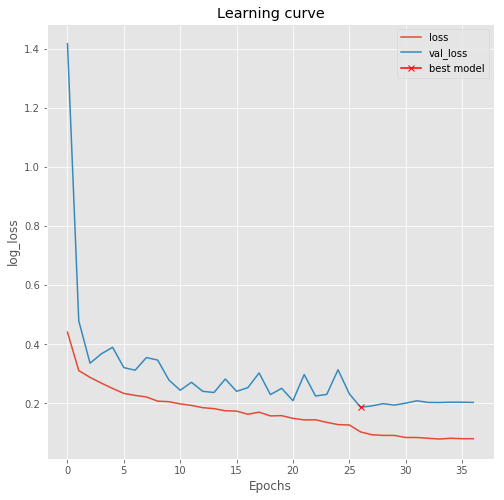

In [17]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

### Inference

In [10]:
# load the best model
model.load_weights('model-tgs-salt.h5')

Evaluate on validation set

In [20]:
# Evaluate on validation set (this must be equals to the best log_loss)
model.evaluate(X_valid, y_valid, verbose=1)

400/400 [==============================] - 0s 1ms/step


[0.18702135920524599, 0.9190425109863282]

Predict on train, val and test

In [11]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_valid, verbose=1)

400/400 [==============================] - 0s 848us/step


Threshold predictions

In [12]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [13]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

### Predictions on training set

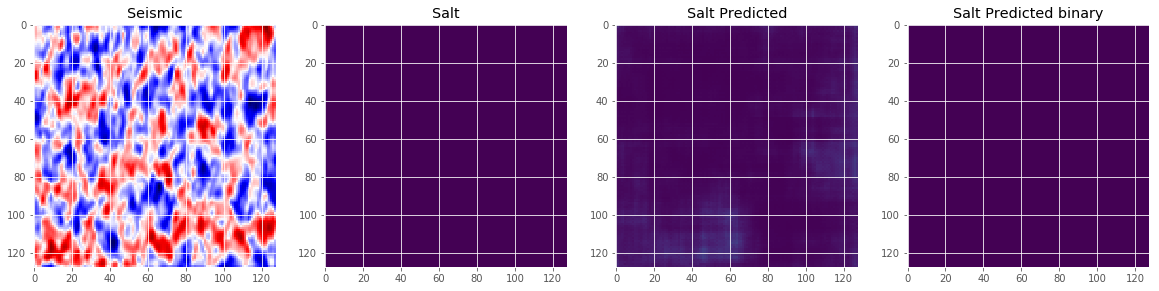

In [24]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

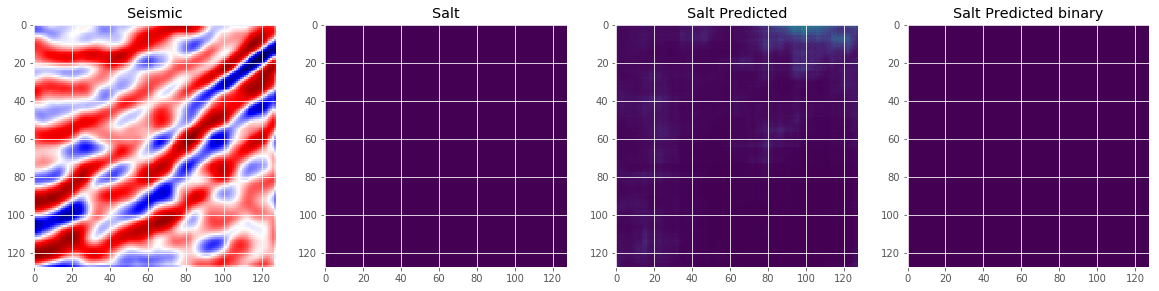

In [14]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

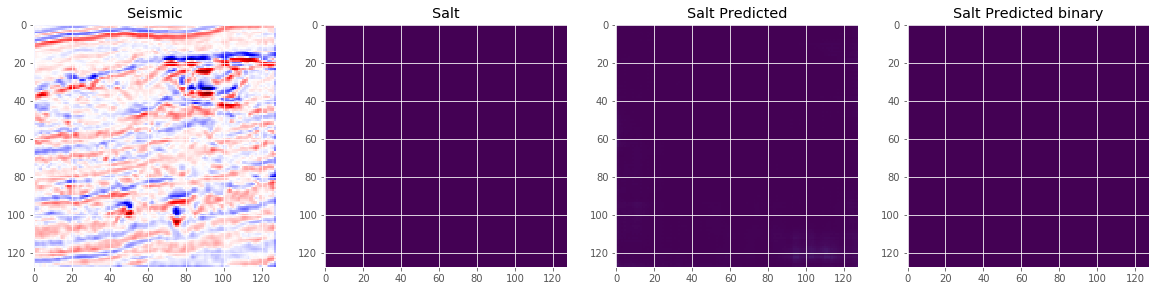

In [15]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

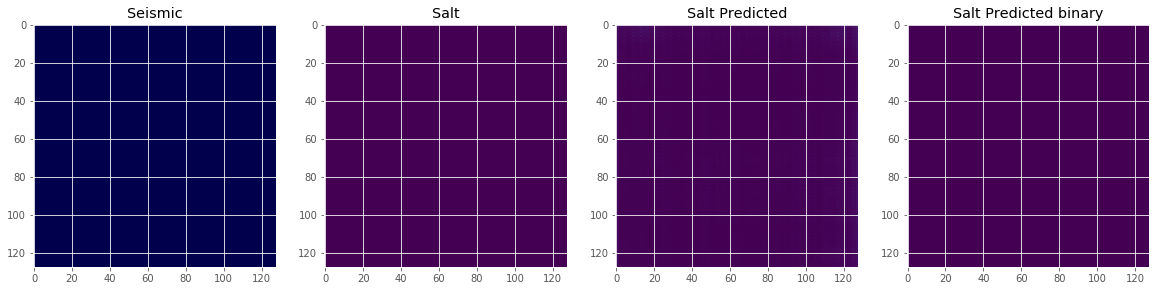

In [16]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

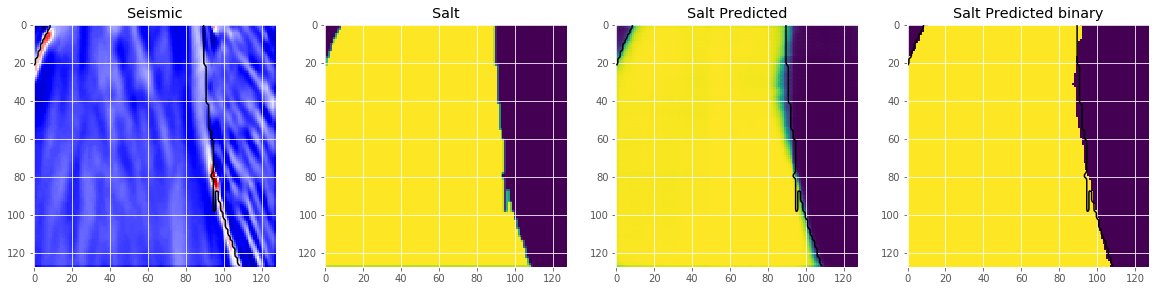

In [17]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

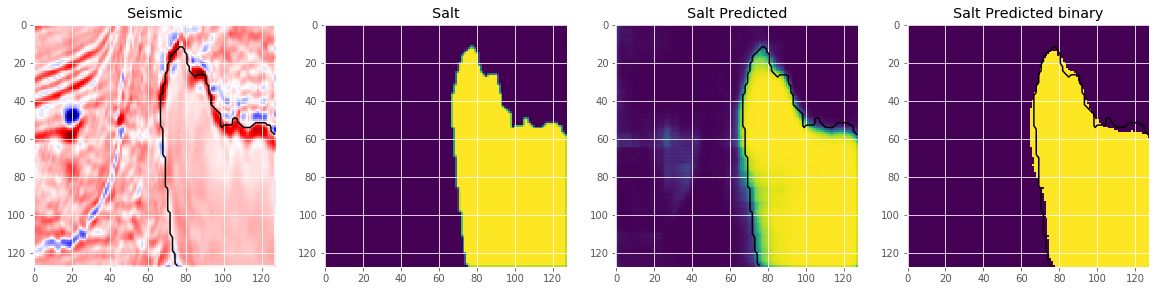

In [18]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

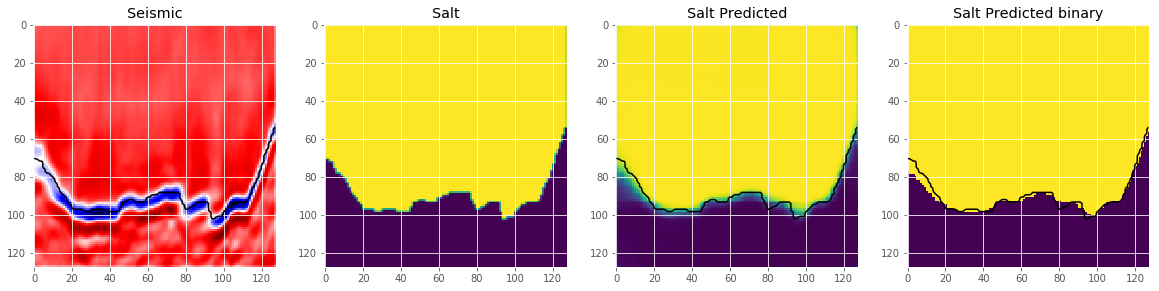

In [19]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

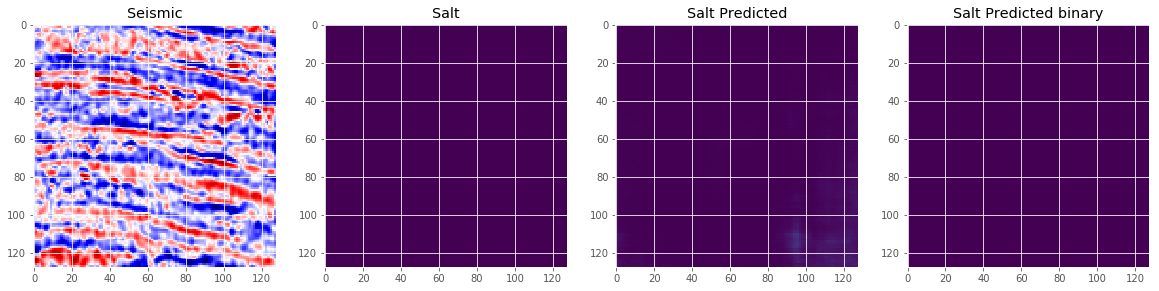

In [20]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

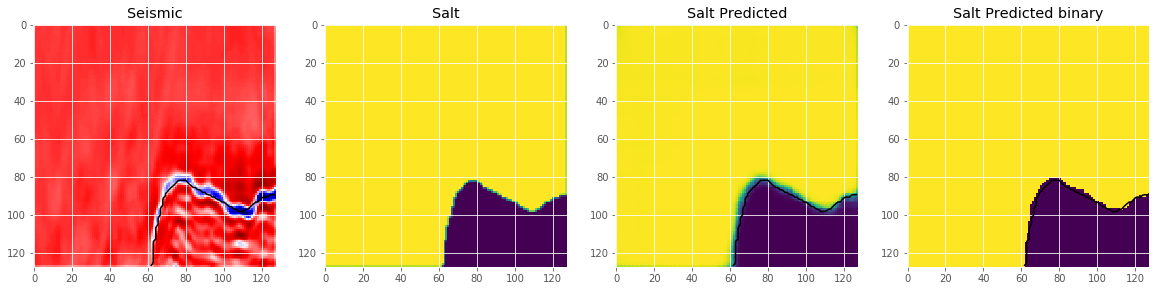

In [21]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

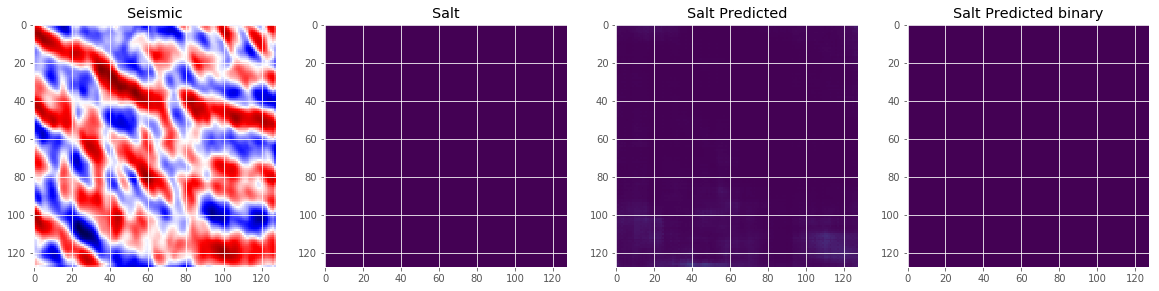

In [22]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

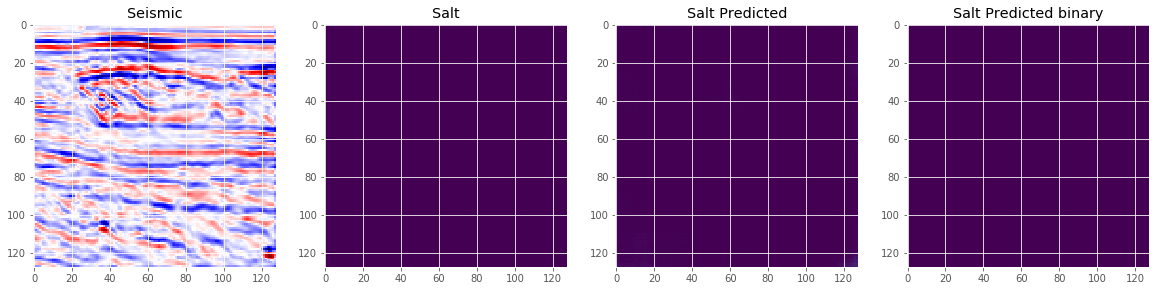

In [23]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

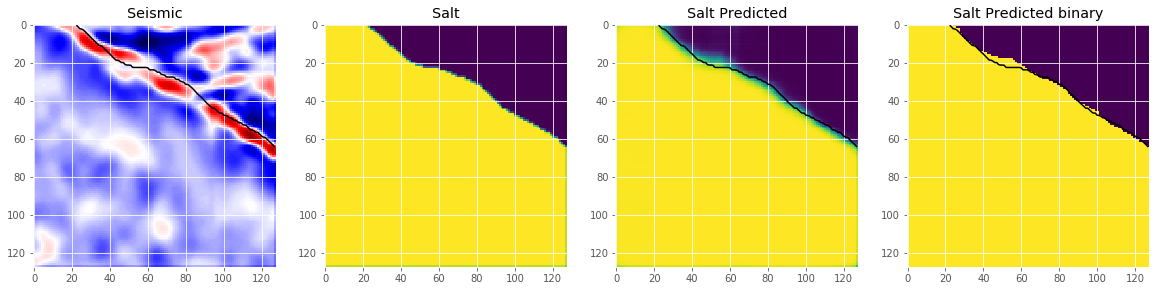

In [24]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

***********************************
### Predictions on Test Set

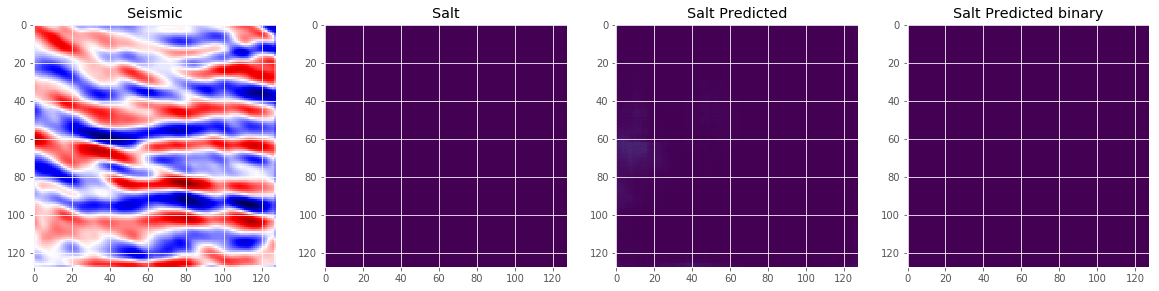

In [25]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=19)

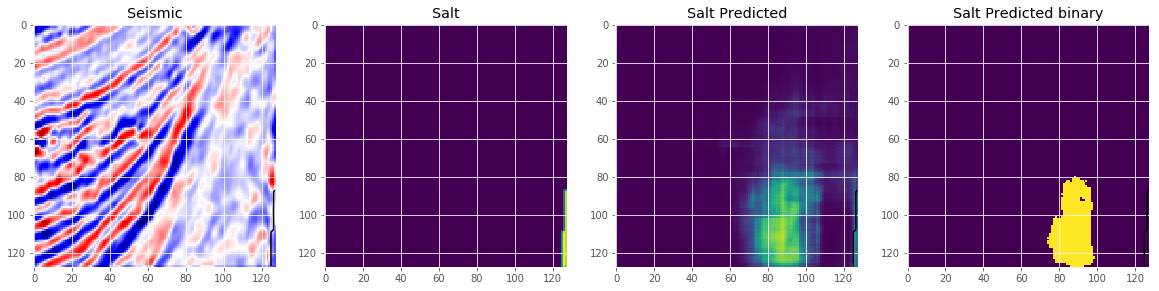

In [25]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

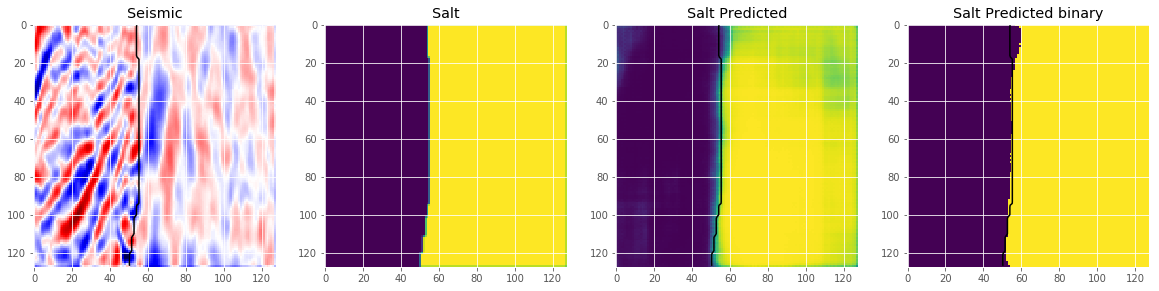

In [26]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

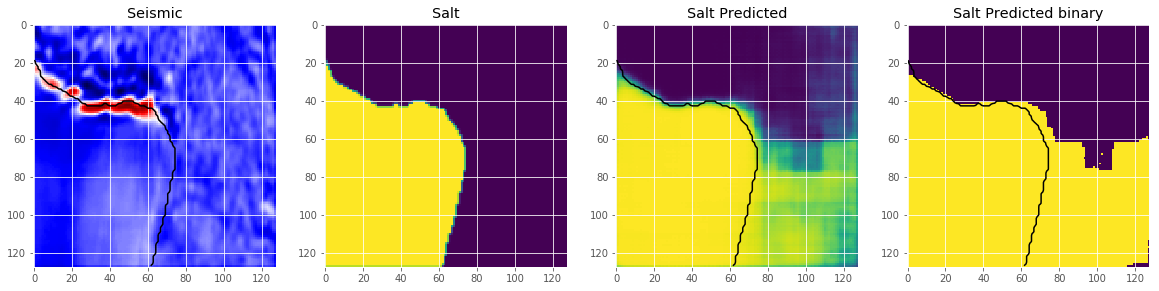

In [27]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

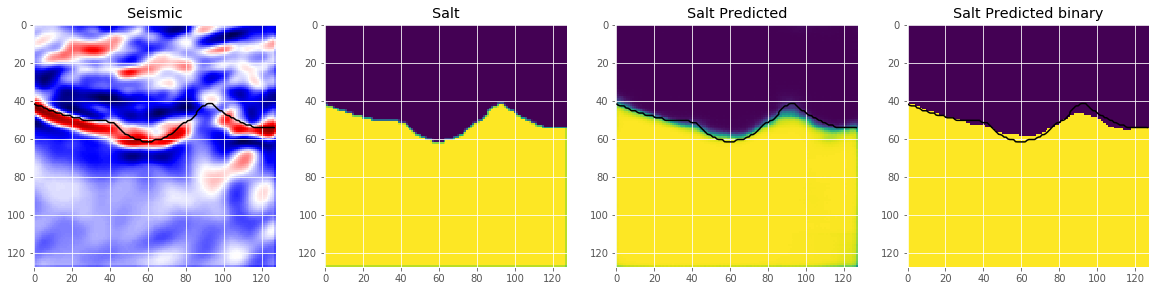

In [28]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

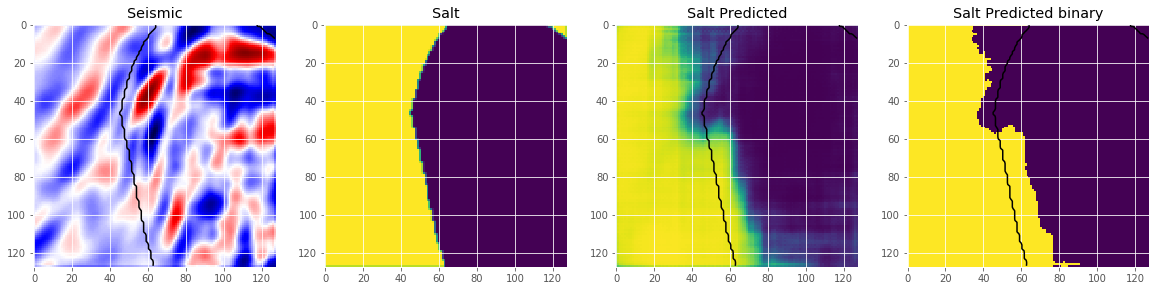

In [29]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

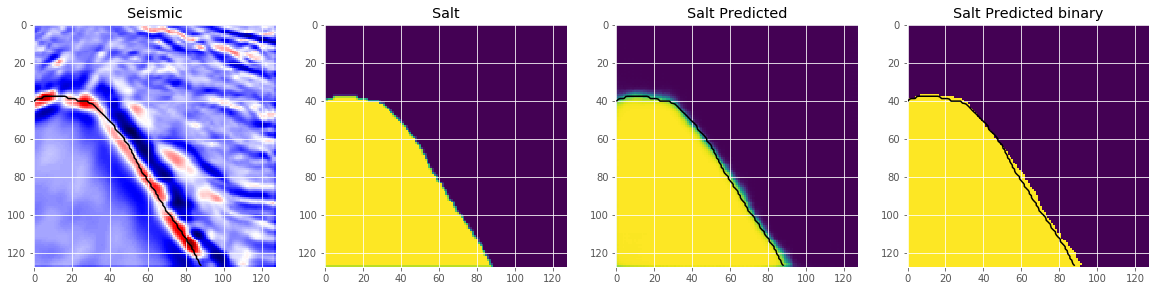

In [30]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

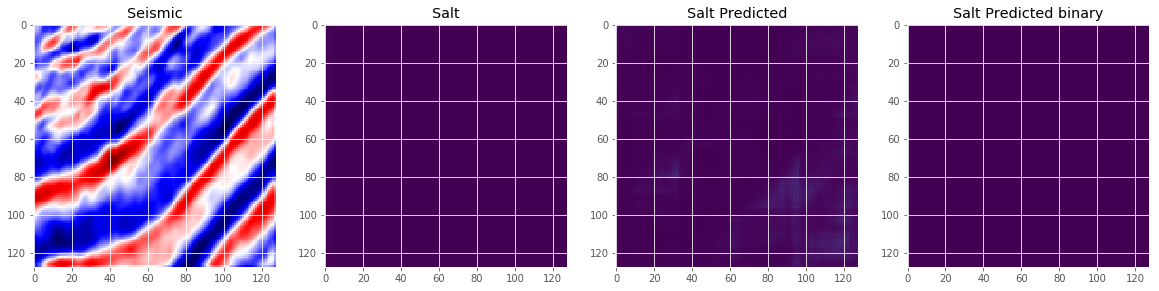

In [31]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

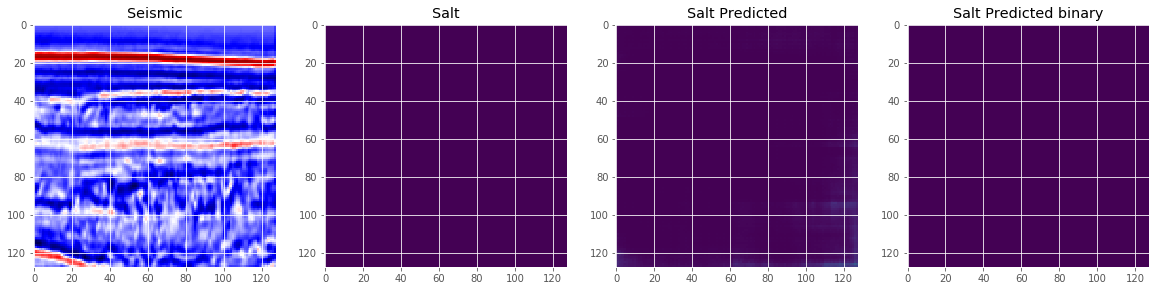

In [32]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

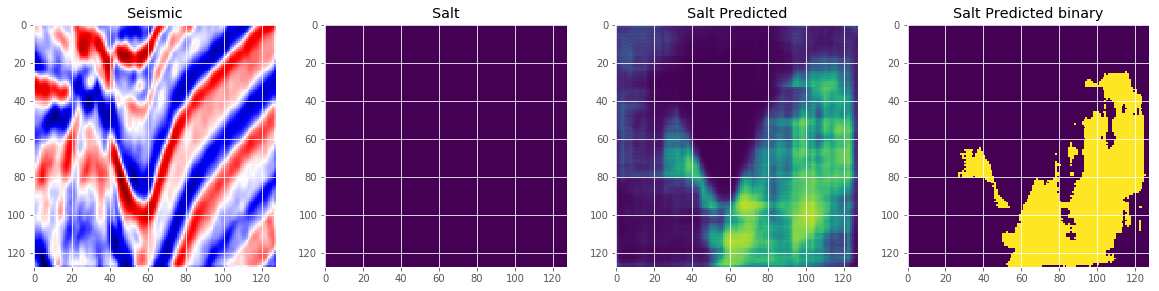

In [33]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

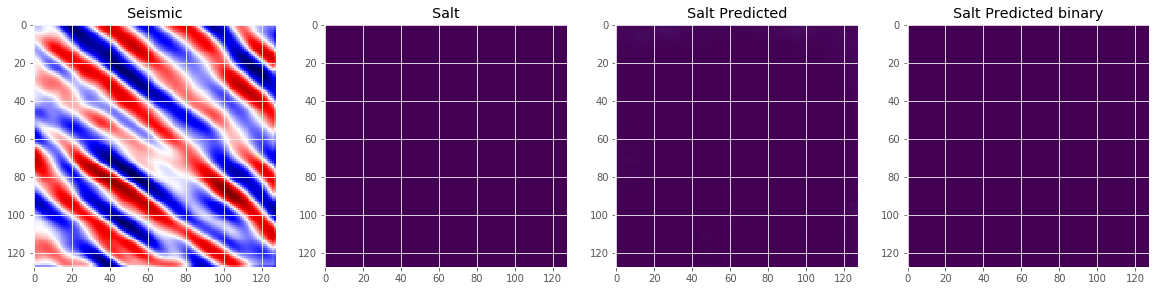

In [34]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

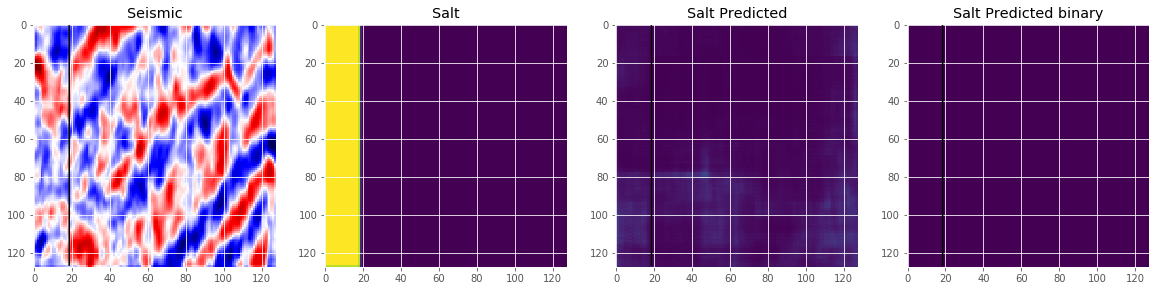

In [35]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

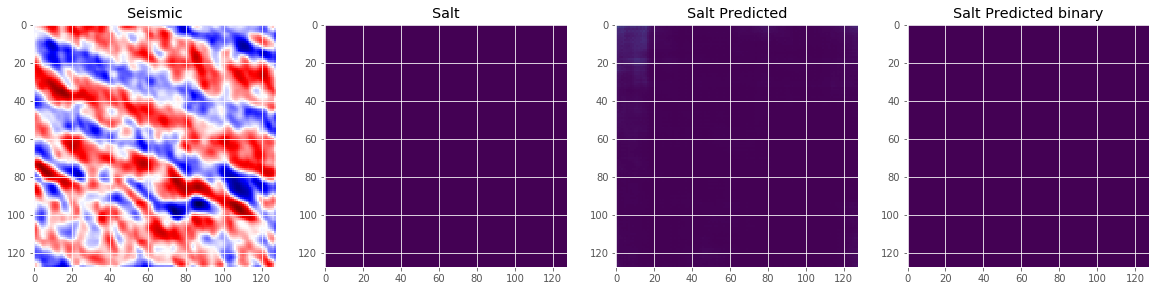

In [36]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

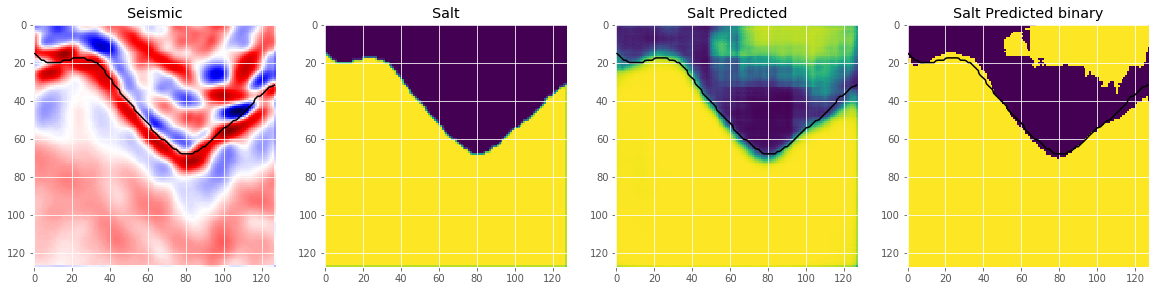

In [37]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

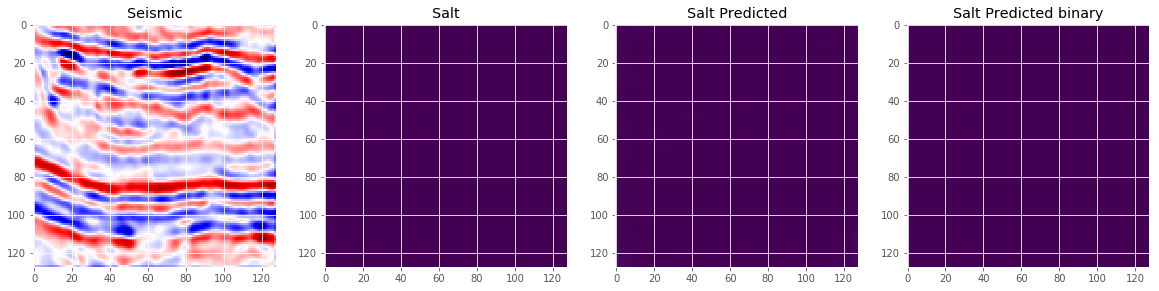

In [38]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

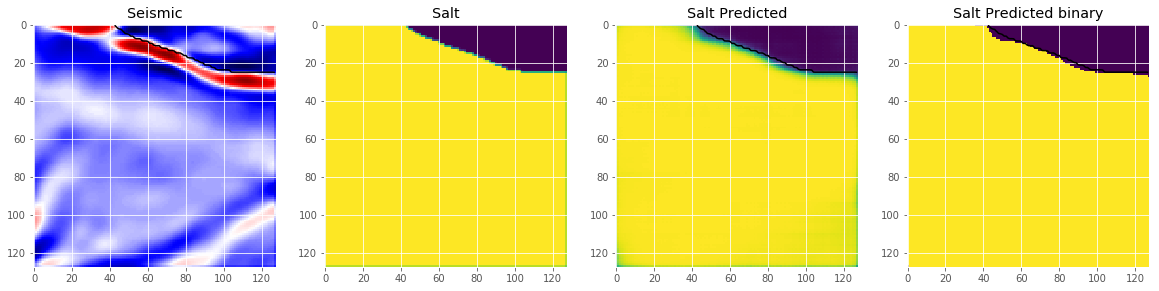

In [39]:
plot_sample(X_valid, y_valid, preds_val, preds_val_t)

******************************************
## Conclusion and Discussion
Here we have deployed two CNN architectures for predicting the Salt images and also the identification of the images and lastly, we have combined both the architectures U-Net and ResNet 34 to produce the final model. After thresolding procedure the model looks better than the previously deployed ones and providing the accuracy scores of more than 90% while identifying the images and more than 97% while predicting the images whether they are salt images or, not!

The identification model or, frame work provides the accuracy of 90%

The Prediction model provides the accuracy of 97%

From my side CNN is the best way to identify this kind of images and creating this kind of image classification models!

********************************************

Hope you like this project! See you in the next one!
Thank you !